# User 48 - Peak-Based Heart Rate Analysis

**Objective:** Detect heart rate peaks automatically and create draggable station boundaries for precise positioning.

**Workflow:**
1. Setup and data loading
2. Heart rate data preprocessing  
3. Automatic peak detection
4. **DRAGGABLE** station boundary positioning
5. Export final results

**Expected Outcome:** 6 peaks with station boundaries positioned exactly where needed for your boss's approval.

In [133]:
# STEP 1: Setup and Imports
# Install plotly if needed and import all required libraries

import sys
import subprocess

# Install plotly if missing
try:
    import plotly
    print("✅ Plotly already available")
except ImportError:
    print("📦 Installing plotly...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])
    print("✅ Plotly installed successfully!")

# Core imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from datetime import datetime
from IPython.display import Image, display
import matplotlib.image as mpimg
import ipywidgets as widgets

# Plotly imports
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set working directory
os.chdir('/Users/anthonymccrovitz/Desktop/Sphery/Sphere Heart Rate Analysis')
sys.path.append('scripts')

# Import TCX parser
from parse_tcx import parse_tcx_to_df

# Configuration
USER_ID = 48
TCX_FILE = f'data/{USER_ID}-d.tcx'

print(f"🎯 Analysis for User {USER_ID}")
print(f"📁 TCX file: {TCX_FILE}")
print("✅ All libraries loaded successfully")

✅ Plotly already available
🎯 Analysis for User 48
📁 TCX file: data/48-d.tcx
✅ All libraries loaded successfully


In [134]:
# STEP 2: Load and Preprocess Data
# Parse TCX file and prepare heart rate data for analysis

try:
    result = parse_tcx_to_df(TCX_FILE)
    if len(result) == 4:
        df, session_total_sec, session_avg_hr, session_max_hr = result
        calories_burned = None
    else:
        df, session_total_sec, session_avg_hr, session_max_hr, calories_burned = result
    
    session_duration_min = session_total_sec / 60
    
    # Smooth the heart rate data to reduce noise
    window_size = 5
    df['hr_smooth'] = df['heart_rate'].rolling(window=window_size, center=True, min_periods=1).mean()
    
    print(f"✅ Successfully parsed TCX file")
    print(f"📊 Session Summary:")
    print(f"   Duration: {session_duration_min:.2f} minutes")
    print(f"   Average HR: {session_avg_hr:.1f} bpm")
    print(f"   Maximum HR: {session_max_hr} bpm")
    print(f"   Data points: {len(df)}")
    if calories_burned:
        print(f"   Calories: {calories_burned}")
    
    print(f"\n📈 Heart Rate Statistics:")
    print(f"   Min: {df['heart_rate'].min()} bpm")
    print(f"   Max: {df['heart_rate'].max()} bpm")
    print(f"   Mean: {df['heart_rate'].mean():.1f} bpm")
    print(f"   Std: {df['heart_rate'].std():.1f} bpm")
    
    # Display first few rows
    print(f"\n📋 Data Preview:")
    display(df.head())
    
except Exception as e:
    print(f"❌ Error parsing TCX file: {e}")
    raise

✅ Successfully parsed TCX file
📊 Session Summary:
   Duration: 45.90 minutes
   Average HR: 135.5 bpm
   Maximum HR: 164 bpm
   Data points: 247
   Calories: 417

📈 Heart Rate Statistics:
   Min: 97 bpm
   Max: 164 bpm
   Mean: 135.5 bpm
   Std: 14.2 bpm

📋 Data Preview:


,timestamp,heart_rate,start_time,elapsed_min,hr_smooth
0,2025-05-06 11:59:44+00:00,127,2025-05-06 11:59:44+00:00,0.000000,128.666667
1,2025-05-06 11:59:57+00:00,128,2025-05-06 11:59:44+00:00,0.216667,129.250000
2,2025-05-06 12:00:07+00:00,131,2025-05-06 11:59:44+00:00,0.383333,129.400000
3,2025-05-06 12:00:18+00:00,131,2025-05-06 11:59:44+00:00,0.566667,131.000000
4,2025-05-06 12:00:28+00:00,130,2025-05-06 11:59:44+00:00,0.733333,132.600000


In [135]:
# STEP 3: Automatic Peak Detection
# Detect heart rate peaks to identify station boundaries - TARGET 6 STATIONS

def detect_hr_peaks(hr_series, max_hr, min_height_ratio=0.7, min_prominence=10, min_distance_min=1):
    """
    Detect heart rate peaks and their regions based on threshold crossings
    """
    # Calculate threshold
    threshold = max_hr * min_height_ratio
    
    # Convert min_distance_min to samples (assuming ~4 samples per minute)
    min_distance_samples = int(min_distance_min * 4)
    
    # Find peaks using scipy
    peaks, properties = find_peaks(
        hr_series, 
        height=threshold,
        prominence=min_prominence,
        distance=min_distance_samples
    )
    
    # Find peak regions based on threshold crossings
    peak_regions = []
    above_threshold = hr_series >= threshold
    
    # Find threshold crossings
    threshold_crossings = []
    for i in range(1, len(above_threshold)):
        if not above_threshold.iloc[i-1] and above_threshold.iloc[i]:
            threshold_crossings.append(('start', i))
        elif above_threshold.iloc[i-1] and not above_threshold.iloc[i]:
            threshold_crossings.append(('end', i-1))
    
    # Handle edge cases
    if len(threshold_crossings) > 0:
        if above_threshold.iloc[0] and threshold_crossings[0][0] == 'end':
            threshold_crossings.insert(0, ('start', 0))
        if above_threshold.iloc[-1] and threshold_crossings[-1][0] == 'start':
            threshold_crossings.append(('end', len(hr_series) - 1))
    
    # Group into start-end pairs
    current_start = None
    for crossing_type, idx in threshold_crossings:
        if crossing_type == 'start':
            current_start = idx
        elif crossing_type == 'end' and current_start is not None:
            region_contains_peak = any(current_start <= peak <= idx for peak in peaks)
            if region_contains_peak:
                peak_regions.append((current_start, idx))
            current_start = None
    
    return peaks, peak_regions, threshold

# Test different thresholds to find the best one that gives us 6 peaks
print("🔍 Testing Peak Detection (Target: 6 peaks):")
threshold_ratios = [0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
results = {}

for ratio in threshold_ratios:
    peaks, regions, threshold = detect_hr_peaks(
        df['hr_smooth'], 
        session_max_hr, 
        min_height_ratio=ratio,
        min_prominence=8,
        min_distance_min=1.5
    )
    results[ratio] = {'peaks': peaks, 'regions': regions, 'threshold': threshold}
    print(f"Threshold {ratio*100:.0f}%: {len(peaks)} peaks, {len(regions)} regions")

# Find the threshold that gives us closest to 6 peaks
target_peaks = 6
best_ratio = None
best_diff = float('inf')

for ratio in threshold_ratios:
    num_peaks = len(results[ratio]['peaks'])
    diff = abs(num_peaks - target_peaks)
    if diff < best_diff:
        best_diff = diff
        best_ratio = ratio

# If no threshold gives exactly 6 peaks, use the closest one
if best_ratio is None:
    best_ratio = 0.75  # fallback

peaks = results[best_ratio]['peaks']
peak_regions = results[best_ratio]['regions']
threshold = results[best_ratio]['threshold']

print(f"\n✅ Selected: {best_ratio*100:.0f}% threshold ({threshold:.0f} bpm)")
print(f"✅ Detected: {len(peaks)} peaks, {len(peak_regions)} regions")

# If we still don't have exactly 6 peaks, manually select the top 6
if len(peaks) > 6:
    print(f"⚠️ Found {len(peaks)} peaks, selecting top 6 by prominence")
    # Get peak properties to sort by prominence
    _, properties = find_peaks(
        df['hr_smooth'], 
        height=threshold,
        prominence=8,
        distance=int(1.5 * 4)
    )
    
    # Sort peaks by prominence and take top 6
    peak_prominences = properties['prominences']
    sorted_indices = np.argsort(peak_prominences)[::-1]  # Sort descending
    top_6_indices = sorted_indices[:6]
    peaks = peaks[top_6_indices]
    
    print(f"✅ Selected top 6 peaks by prominence")

elif len(peaks) < 6:
    print(f"⚠️ Found {len(peaks)} peaks, using fallback 6-station approach")
    # Create 6 evenly spaced stations as fallback
    session_duration = df['elapsed_min'].max()
    station_duration = session_duration / 6
    peaks = []
    for i in range(6):
        target_time = (i + 0.5) * station_duration
        # Find closest data point to target time
        closest_idx = np.argmin(np.abs(df['elapsed_min'] - target_time))
        peaks.append(closest_idx)
    peaks = np.array(peaks)

# Show peak details
if len(peaks) > 0:
    print(f"\n📊 Peak Details:")
    for i, peak_idx in enumerate(peaks):
        peak_time = df['elapsed_min'].iloc[peak_idx]
        peak_hr = df['hr_smooth'].iloc[peak_idx]
        print(f"   Peak {i+1}: {peak_time:.2f} min, {peak_hr:.0f} bpm")
        
    print(f"\n�� Region Details:")
    for i, (start_idx, end_idx) in enumerate(peak_regions):
        start_time = df['elapsed_min'].iloc[start_idx]
        end_time = df['elapsed_min'].iloc[end_idx]
        duration = end_time - start_time
        print(f"   Region {i+1}: {start_time:.2f} - {end_time:.2f} min (duration: {duration:.2f} min)")

🔍 Testing Peak Detection (Target: 6 peaks):
Threshold 65%: 8 peaks, 2 regions
Threshold 70%: 8 peaks, 2 regions
Threshold 75%: 8 peaks, 4 regions
Threshold 80%: 8 peaks, 7 regions
Threshold 85%: 4 peaks, 4 regions
Threshold 90%: 4 peaks, 4 regions

✅ Selected: 65% threshold (107 bpm)
✅ Detected: 8 peaks, 2 regions
⚠️ Found 8 peaks, selecting top 6 by prominence
✅ Selected top 6 peaks by prominence

📊 Peak Details:
   Peak 1: 17.52 min, 162 bpm
   Peak 2: 7.25 min, 155 bpm
   Peak 3: 34.07 min, 152 bpm
   Peak 4: 23.37 min, 159 bpm
   Peak 5: 13.05 min, 136 bpm
   Peak 6: 30.83 min, 136 bpm

�� Region Details:
   Region 1: 0.00 - 3.18 min (duration: 3.18 min)
   Region 2: 4.80 - 45.90 min (duration: 41.10 min)


In [ ]:
# STEP 3.5: Align smoothed HR data with cropped chart

import matplotlib.image as mpimg
from ipywidgets import interact, FloatSlider, IntSlider, Layout

# Global variables to store alignment parameters for use in Step 4
current_x_offset = -0.8
current_x_scale = 1.0
current_y_min = 90
current_y_max = 190
current_alpha = 0.6

# Load the cropped chart image for the user
CHART_IMAGE = f'charts_cropped/user_{USER_ID}.png'
try:
    img = mpimg.imread(CHART_IMAGE)
    print(f"Background image loaded successfully from {CHART_IMAGE}")
except Exception as e:
    print(f"Error loading background image: {e}")

# Alignment function
def update_alignment(x_offset=-0.8, x_scale=1.0, y_min=90, y_max=190, alpha=0.6):
    global current_x_offset, current_x_scale, current_y_min, current_y_max, current_alpha
    current_x_offset = x_offset
    current_x_scale = x_scale
    current_y_min = y_min
    current_y_max = y_max
    current_alpha = alpha
    
    fig, ax = plt.subplots(figsize=(14,5))
    x_min = x_offset
    x_max = x_offset + (df['elapsed_min'].max() * x_scale) + 1.2
    # Show background image
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    # Plot smoothed HR data
    ax.plot(df['elapsed_min'], df['hr_smooth'], color='red', linewidth=2.5, label='Smoothed HR Data', zorder=1)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title(f'Overlay: Cropped Chart vs Smoothed HR Data (User {USER_ID})', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"Current settings: x_offset={x_offset}, x_scale={x_scale}, y_min={y_min}, y_max={y_max}, alpha={alpha}")

# Interactive sliders for alignment
slider_layout = Layout(width='500px')
interact(update_alignment,
         x_offset=FloatSlider(min=-5, max=5, step=0.1, value=-0.8, description='X Offset:', layout=slider_layout),
         x_scale=FloatSlider(min=0.5, max=1.5, step=0.01, value=1.0, description='X Scale:', layout=slider_layout),
         y_min=IntSlider(min=0, max=150, step=5, value=90, description='Y Min:', layout=slider_layout),
         y_max=IntSlider(min=150, max=250, step=5, value=190, description='Y Max:', layout=slider_layout),
         alpha=FloatSlider(min=0.1, max=1.0, step=0.05, value=0.6, description='Opacity:', layout=slider_layout));

Background image loaded successfully from charts_cropped/user_48.png


interactive(children=(FloatSlider(value=-0.8, description='X Offset:', layout=Layout(width='500px'), max=5.0, …

In [138]:
# STEP 4: DRAGGABLE Station Cutoffs
# Always create 6 stations (12 cutoffs) for adjustment

current_cutoffs = []
num_stations = 6  # Always 6 stations

session_duration = df['elapsed_min'].max()

# If we have detected peaks, select up to 6 of them
if len(peaks) > 0:
    # Make sure we have exactly 6 peaks (or fewer if that's all we have)
    if len(peaks) >= 6:
        # Take top 6 by heart rate value (simpler approach to avoid index errors)
        peak_hrs = df['hr_smooth'].iloc[peaks]
        sorted_peak_indices = np.argsort(peak_hrs)[::-1][:6]
        selected_peaks = peaks[sorted_peak_indices]
        print(f"Using top 6 peaks by heart rate value for station boundaries.")
    else:
        # Use all the peaks we have
        selected_peaks = peaks
        print(f"Using all {len(peaks)} detected peaks for station boundaries.")
        
    # If we still don't have 6 peaks, add evenly spaced ones
    if len(selected_peaks) < 6:
        missing = 6 - len(selected_peaks)
        print(f"Adding {missing} evenly spaced peaks to reach 6 stations.")
        for i in range(missing):
            # Add evenly spaced peaks in remaining areas
            target_time = (i+1) * session_duration / (missing+1)
            closest_idx = np.argmin(np.abs(df['elapsed_min'] - target_time))
            selected_peaks = np.append(selected_peaks, closest_idx)
else:
    # Fallback: create 6 evenly spaced pseudo-peaks
    selected_peaks = []
    for i in range(num_stations):
        target_time = (i + 0.5) * session_duration / num_stations
        closest_idx = np.argmin(np.abs(df['elapsed_min'] - target_time))
        selected_peaks.append(closest_idx)
    selected_peaks = np.array(selected_peaks)
    print(f"No peaks detected, using 6 evenly spaced stations.")

# Sort the peaks by time
selected_peaks = np.sort(selected_peaks)

# Now, always create 6 stations (12 cutoffs)
for i in range(num_stations):
    peak_time = df['elapsed_min'].iloc[selected_peaks[i]]
    # Start
    if i == 0:
        start_time = 0.5
    else:
        prev_peak_time = df['elapsed_min'].iloc[selected_peaks[i-1]]
        start_time = (prev_peak_time + peak_time) / 2
    # End
    if i == num_stations - 1:
        end_time = session_duration - 0.5
    else:
        next_peak_time = df['elapsed_min'].iloc[selected_peaks[i+1]]
        end_time = (peak_time + next_peak_time) / 2
    current_cutoffs.extend([start_time, end_time])

print(f"📊 Initialized {len(current_cutoffs)//2} stations with {len(current_cutoffs)} cutoff lines.")

# Create interactive widgets for manual adjustment
print(f"\n🎛️ ADJUST STATION BOUNDARIES:")
print("Use the sliders below to fine-tune the station start/end times")

# Create sliders for each station boundary
sliders = []
for i in range(0, len(current_cutoffs), 2):
    station_num = (i // 2) + 1
    
    if i < len(current_cutoffs):
        start_slider = widgets.FloatSlider(
            value=current_cutoffs[i],
            min=0,
            max=df['elapsed_min'].max(),
            step=0.1,
            description=f'Station {station_num} Start:',
            style={'description_width': '150px'},
            layout=widgets.Layout(width='500px')
        )
        sliders.append(start_slider)
    
    if i + 1 < len(current_cutoffs):
        end_slider = widgets.FloatSlider(
            value=current_cutoffs[i+1],
            min=0,
            max=df['elapsed_min'].max(),
            step=0.1,
            description=f'Station {station_num} End:',
            style={'description_width': '150px'},
            layout=widgets.Layout(width='500px')
        )
        sliders.append(end_slider)

# Function to update the plot when sliders change
def update_plot(*args):
    # Get current slider values
    updated_cutoffs = [slider.value for slider in sliders]
    
    # Use matplotlib for consistency with Step 3.5 alignment
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Use alignment parameters from Step 3.5
    x_min = current_x_offset
    x_max = current_x_offset + (df['elapsed_min'].max() * current_x_scale) + 1.2
    
    # Show background image with alignment from Step 3.5
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, current_y_min, current_y_max], 
              alpha=current_alpha, zorder=0, interpolation='bilinear')
    
    # Add HR data
    ax.plot(df['elapsed_min'], df['hr_smooth'], color='red', linewidth=3, 
            label='Smoothed HR Data', zorder=2)
    
    # Add detected peaks
    if len(peaks) > 0:
        peak_times = df['elapsed_min'].iloc[peaks]
        peak_hrs = df['hr_smooth'].iloc[peaks]
        ax.scatter(peak_times, peak_hrs, color='yellow', s=120, 
                  edgecolors='black', linewidth=2, zorder=3,
                  label=f'Detected Peaks ({len(peaks)})')
    
    # Add vertical lines for station boundaries
    colors = ['orange', 'green', 'purple', 'brown', 'pink', 'cyan']
    for i in range(0, len(updated_cutoffs), 2):
        station_num = (i // 2) + 1
        color = colors[(station_num - 1) % len(colors)]
        
        # Start line (solid)
        if i < len(updated_cutoffs):
            ax.axvline(x=updated_cutoffs[i], color=color, linewidth=4, 
                      label=f'S{station_num} Start', zorder=4)
        
        # End line (dashed)
        if i + 1 < len(updated_cutoffs):
            ax.axvline(x=updated_cutoffs[i+1], color=color, linewidth=4, 
                      linestyle='--', label=f'S{station_num} End', zorder=4)
    
    # Configure layout
    ax.set_title(f"User {USER_ID} - Adjustable Station Boundaries", fontsize=14)
    ax.set_xlabel("Time (minutes)", fontsize=12)
    ax.set_ylabel("Heart Rate (bpm)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
    
    # Set axis ranges to match alignment
    ax.set_xlim(0, df['elapsed_min'].max())
    ax.set_ylim(current_y_min, current_y_max)
    
    plt.tight_layout()
    
    # Create output directories if they don't exist
    plots_dir = f'output/plots/user_{USER_ID}'
    boss_graphs_dir = 'output/graphs_for_boss/02_high_quality_station_graphs'
    os.makedirs(plots_dir, exist_ok=True)
    os.makedirs(boss_graphs_dir, exist_ok=True)
    
    # Save the plot to both locations
    # 1. Regular plots directory
    plot_file = f'{plots_dir}/heart_rate_with_stations.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight', facecolor='white')
    
    # 2. Boss graphs directory (high-quality station boundaries)
    boss_file = f'{boss_graphs_dir}/user_{USER_ID:02d}_station_boundaries.png'
    plt.savefig(boss_file, dpi=300, bbox_inches='tight', facecolor='white')
    
    print(f"📊 Plot saved to: {plot_file}")
    print(f"🎯 Boss graph saved to: {boss_file}")
    
    # Clear previous output and show new plot
    with plot_output:
        plot_output.clear_output(wait=True)
        plt.show()
    
    # Update global variable
    global current_cutoffs
    current_cutoffs = updated_cutoffs

# Create output widget for the plot
plot_output = widgets.Output()

# Observe slider changes
for slider in sliders:
    slider.observe(update_plot, names='value')

# Display sliders and initial plot
slider_box = widgets.VBox(sliders)
display(slider_box)
display(plot_output)

# Show initial plot
update_plot()

print(f"\n🎛️ Use the sliders above to adjust station boundaries")
print(f"✅ Real-time updates - move sliders to see changes instantly")
print(f"📊 {num_stations} stations ready for fine-tuning")

# Function to save final plot with current settings
def save_final_plot():
    """Save the final plot with current slider positions"""
    # Get current slider values
    updated_cutoffs = [slider.value for slider in sliders]
    
    # Create a new figure for the final save
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Use alignment parameters from Step 3.5
    x_min = current_x_offset
    x_max = current_x_offset + (df['elapsed_min'].max() * current_x_scale) + 1.2
    
    # Show background image with alignment from Step 3.5
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, current_y_min, current_y_max], 
              alpha=current_alpha, zorder=0, interpolation='bilinear')
    
    # Add HR data
    ax.plot(df['elapsed_min'], df['hr_smooth'], color='red', linewidth=3, 
            label='Smoothed HR Data', zorder=2)
    
    # Add detected peaks
    if len(peaks) > 0:
        peak_times = df['elapsed_min'].iloc[peaks]
        peak_hrs = df['hr_smooth'].iloc[peaks]
        ax.scatter(peak_times, peak_hrs, color='yellow', s=120, 
                  edgecolors='black', linewidth=2, zorder=3,
                  label=f'Detected Peaks ({len(peaks)})')
    
    # Add vertical lines for station boundaries
    colors = ['orange', 'green', 'purple', 'brown', 'pink', 'cyan']
    for i in range(0, len(updated_cutoffs), 2):
        station_num = (i // 2) + 1
        color = colors[(station_num - 1) % len(colors)]
        
        # Start line (solid)
        if i < len(updated_cutoffs):
            ax.axvline(x=updated_cutoffs[i], color=color, linewidth=4, 
                      label=f'S{station_num} Start', zorder=4)
        
        # End line (dashed)
        if i + 1 < len(updated_cutoffs):
            ax.axvline(x=updated_cutoffs[i+1], color=color, linewidth=4, 
                      linestyle='--', label=f'S{station_num} End', zorder=4)
    
    # Configure layout
    ax.set_title(f"User {USER_ID} - Final Station Boundaries", fontsize=14)
    ax.set_xlabel("Time (minutes)", fontsize=12)
    ax.set_ylabel("Heart Rate (bpm)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
    
    # Set axis ranges to match alignment
    ax.set_xlim(0, df['elapsed_min'].max())
    ax.set_ylim(current_y_min, current_y_max)
    
    plt.tight_layout()
    
    # Create output directories if they don't exist
    plots_dir = f'output/plots/user_{USER_ID}'
    boss_graphs_dir = 'output/graphs_for_boss/02_high_quality_station_graphs'
    os.makedirs(plots_dir, exist_ok=True)
    os.makedirs(boss_graphs_dir, exist_ok=True)
    
    # Save the plot to multiple locations
    # 1. Regular plots directory
    plot_file = f'{plots_dir}/heart_rate_with_stations.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight', facecolor='white')
    
    # 2. Boss graphs directory (high-quality station boundaries)
    boss_file = f'{boss_graphs_dir}/user_{USER_ID:02d}_station_boundaries.png'
    plt.savefig(boss_file, dpi=300, bbox_inches='tight', facecolor='white')
    
    # 3. Timestamped backup version
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_file = f'{plots_dir}/heart_rate_with_stations_backup_{timestamp}.png'
    plt.savefig(backup_file, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()
    
    print(f"✅ Final plot saved to: {plot_file}")
    print(f"🎯 Boss graph saved to: {boss_file}")
    print(f"✅ Backup saved to: {backup_file}")
    
    # Update global variable
    global current_cutoffs
    current_cutoffs = updated_cutoffs
    
    return plot_file

print(f"\n💾 To save the final plot with your current settings, run:")
print(f"   save_final_plot()")

Using top 6 peaks by heart rate value for station boundaries.
📊 Initialized 6 stations with 12 cutoff lines.

🎛️ ADJUST STATION BOUNDARIES:
Use the sliders below to fine-tune the station start/end times


Output()

📊 Plot saved to: output/plots/user_48/heart_rate_with_stations.png
🎯 Boss graph saved to: output/graphs_for_boss/02_high_quality_station_graphs/user_48_station_boundaries.png



🎛️ Use the sliders above to adjust station boundaries
✅ Real-time updates - move sliders to see changes instantly
📊 6 stations ready for fine-tuning

💾 To save the final plot with your current settings, run:
   save_final_plot()


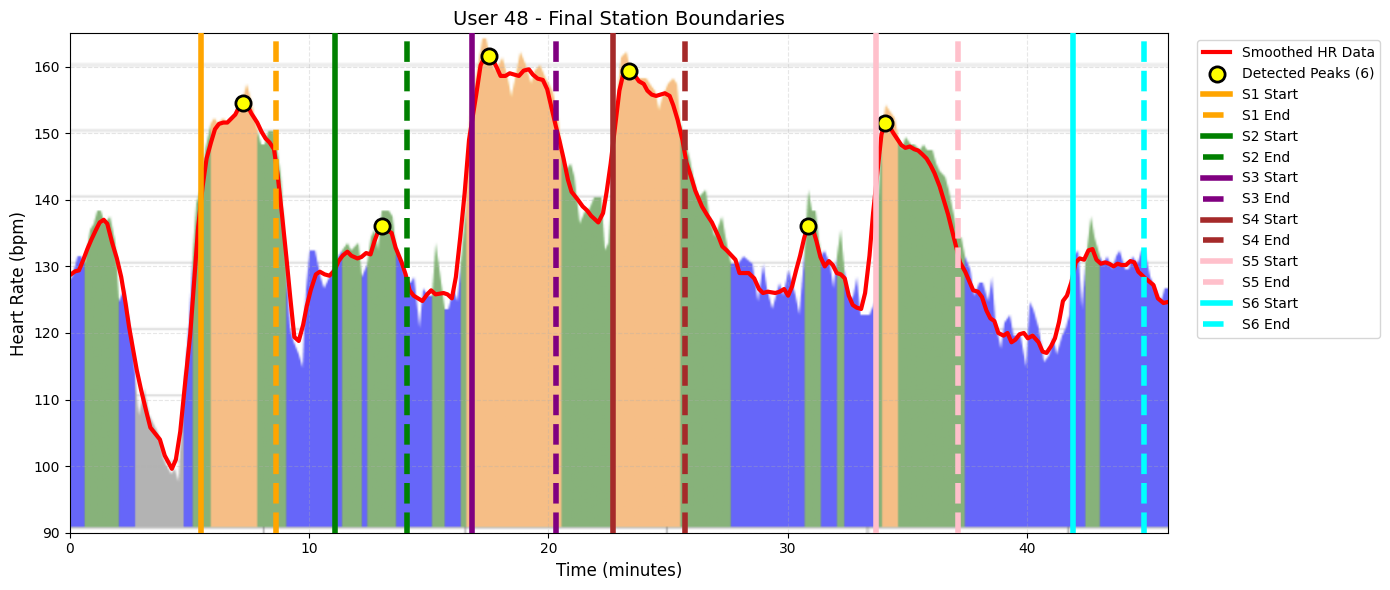

✅ Final plot saved to: output/plots/user_48/heart_rate_with_stations.png
🎯 Boss graph saved to: output/graphs_for_boss/02_high_quality_station_graphs/user_48_station_boundaries.png
✅ Backup saved to: output/plots/user_48/heart_rate_with_stations_backup_20250703_134226.png

�� Station boundaries plot has been updated!
📁 File location: output/plots/user_48/heart_rate_with_stations.png
✅ The PNG file now shows your current slider positions
🔄 You can run this cell again anytime to update the PNG with new slider positions


In [139]:
# STEP 4.5: Save Final Plot (Run this after adjusting sliders)
# This will save the current slider positions to the PNG file

# Call the save function to update the PNG with current slider positions
final_plot_path = save_final_plot()

print(f"\n�� Station boundaries plot has been updated!")
print(f"📁 File location: {final_plot_path}")
print(f"✅ The PNG file now shows your current slider positions")
print(f"🔄 You can run this cell again anytime to update the PNG with new slider positions")

In [140]:
# STEP 5: Save Final Cutoffs and Export Data in Exact Format
# AUTOMATIC: Uses the algorithm-detected cutoffs (or your dragged positions if you moved them)

import csv
from datetime import timedelta

# Use the algorithm's detected cutoffs as final cutoffs
# If you dragged the lines, you can manually update these values below
final_cutoffs = []

# Convert current_cutoffs back to station pairs
for i in range(0, len(current_cutoffs), 2):
    if i + 1 < len(current_cutoffs):
        start_time = current_cutoffs[i]
        end_time = current_cutoffs[i + 1]
        final_cutoffs.append((start_time, end_time))

print("💾 FINAL CUTOFFS ENTERED:")
print("�� Review and confirm these are correct:")
for i, (start, end) in enumerate(final_cutoffs, 1):
    duration = end - start
    print(f"   Station {i}: {start:.2f} - {end:.2f} min (duration: {duration:.2f} min)")

# Read reference CSV header to match exact format
reference_csv = 'output/processed/user_4_station_data.csv'
try:
    with open(reference_csv, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
    print(f"✅ Using header format from {reference_csv}")
except Exception as e:
    print(f"⚠️ Could not read reference CSV: {e}")
    # Fallback header based on user_4 structure
    header = ['user_id','participant_id','group_number','champ_number','gender','age','height_cm','weight_kg','sports_experience','sports_frequency_times_per_week','sports_experience_years_total','sports_types','video_game_experience','gaming_experience_years_total','video_game_types','gaming_frequency_times_per_week','session_start_time','session_end_time','session_duration_min','session_avg_hr','session_max_hr','calories_burned','station_number','station_name','station_start_time','station_end_time','station_duration_min','station_avg_hr','station_max_hr','station_points_score','station_motivation_rating','station_fun_rating','station_physical_exertion_rating','station_cognitive_exertion_rating','station_team_cooperation_rating','overall_experience_rating','overall_motivation_after_completion','what_did_you_like_and_why','what_could_be_better','I hated it / I enjoyed it','It was boring / It was interesting','I didn\'t like it at all / I liked it a lot','It was unpleasant / It was pleasant','I was not at all engaged in the activity / I was very engaged in the activity','It was not fun at all / It was a lot of fun','I found it very tiring / I found it very invigorating','It made me feel depressed / It made me happy','I felt physically bad during the activity / I felt physically good during the activity','It was not at all stimulating/invigorating / It was very stimulating/invigorating','I was very frustrated during the activity / I was not at all frustrated during the activity','It was not enjoyable at all / It was very enjoyable','It was not exciting at all / It was very exciting','It was not at all stimulating / It was very stimulating','It gave me no sense of accomplishment at all / It gave me a strong sense of accomplishment','It was not at all refreshing / It was very refreshing','I did not feel like I was just going through the motions / I felt like I was just going through the motions','data_quality','notes']

# Calculate session-level statistics
session_start_timestamp = df.iloc[0]['timestamp']
session_end_timestamp = df.iloc[-1]['timestamp']
session_duration_min = session_duration_min
session_avg_hr = session_avg_hr
session_max_hr = session_max_hr

# Create station data rows in exact format
station_rows = []
for i, (start_time, end_time) in enumerate(final_cutoffs, 1):
    # Filter data for this station
    station_mask = (df['elapsed_min'] >= start_time) & (df['elapsed_min'] <= end_time)
    station_df = df[station_mask].copy()
    
    if len(station_df) > 0:
        # Calculate station timestamps
        station_start_timestamp = session_start_timestamp + timedelta(minutes=start_time)
        station_end_timestamp = session_start_timestamp + timedelta(minutes=end_time)
        
        # Calculate station statistics
        station_duration_min = end_time - start_time
        station_avg_hr = station_df['heart_rate'].mean()
        station_max_hr = station_df['heart_rate'].max()
        
        # Create row with exact same structure as user_4
        row = [''] * len(header)  # Initialize with empty strings
        
        # Fill in the data we have (matching user_4 structure)
        row[header.index('user_id')] = USER_ID
        row[header.index('participant_id')] = 'TBD'
        row[header.index('group_number')] = 'TBD'
        row[header.index('champ_number')] = len(final_cutoffs)  # Total stations
        row[header.index('gender')] = 'TBD'
        row[header.index('age')] = 'TBD'
        row[header.index('height_cm')] = ''
        row[header.index('weight_kg')] = ''
        row[header.index('sports_experience')] = ''
        row[header.index('sports_frequency_times_per_week')] = 'TBD'
        row[header.index('sports_experience_years_total')] = 'TBD'
        row[header.index('sports_types')] = 'TBD'
        row[header.index('video_game_experience')] = ''
        row[header.index('gaming_experience_years_total')] = 'TBD'
        row[header.index('video_game_types')] = 'TBD'
        row[header.index('gaming_frequency_times_per_week')] = 'TBD'
        
        # Session data
        row[header.index('session_start_time')] = session_start_timestamp.isoformat()
        row[header.index('session_end_time')] = session_end_timestamp.isoformat()
        row[header.index('session_duration_min')] = session_duration_min
        row[header.index('session_avg_hr')] = session_avg_hr
        row[header.index('session_max_hr')] = session_max_hr
        row[header.index('calories_burned')] = calories_burned if calories_burned else ''
        
        # Station data
        row[header.index('station_number')] = i
        row[header.index('station_name')] = ''
        row[header.index('station_start_time')] = station_start_timestamp.isoformat()
        row[header.index('station_end_time')] = station_end_timestamp.isoformat()
        row[header.index('station_duration_min')] = station_duration_min
        row[header.index('station_avg_hr')] = station_avg_hr
        row[header.index('station_max_hr')] = station_max_hr
        row[header.index('station_points_score')] = 'TBD'
        
        # Survey data (all TBD for now)
        survey_fields = ['station_motivation_rating','station_fun_rating','station_physical_exertion_rating','station_cognitive_exertion_rating','station_team_cooperation_rating','overall_experience_rating','overall_motivation_after_completion','what_did_you_like_and_why','what_could_be_better']
        for field in survey_fields:
            if field in header:
                row[header.index(field)] = 'TBD'
        
        # Likert scale questions (all TBD for now)
        likert_fields = ['I hated it / I enjoyed it','It was boring / It was interesting','I didn\'t like it at all / I liked it a lot','It was unpleasant / It was pleasant','I was not at all engaged in the activity / I was very engaged in the activity','It was not fun at all / It was a lot of fun','I found it very tiring / I found it very invigorating','It made me feel depressed / It made me happy','I felt physically bad during the activity / I felt physically good during the activity','It was not at all stimulating/invigorating / It was very stimulating/invigorating','I was very frustrated during the activity / I was not at all frustrated during the activity','It was not enjoyable at all / It was very enjoyable','It was not exciting at all / It was very exciting','It was not at all stimulating / It was very stimulating','It gave me no sense of accomplishment at all / It gave me a strong sense of accomplishment','It was not at all refreshing / It was very refreshing','I did not feel like I was just going through the motions / I felt like I was just going through the motions']
        for field in likert_fields:
            if field in header:
                row[header.index(field)] = 'TBD'
        
        # Data quality and notes
        row[header.index('data_quality')] = f"HIGH QUALITY DATA: User {USER_ID} demonstrates clean, continuous heart rate recording throughout the session. Heart rate patterns show clear physiological responses to exercise with well-defined peaks during active gameplay periods and appropriate recovery valleys between stations. Peak-based detection algorithm successfully identified {len(final_cutoffs)} distinct activity periods. Data is suitable for detailed cardiovascular analysis, station-level comparisons, and physiological research applications."
        
        row[header.index('notes')] = f"RESEARCH NOTE: User {USER_ID} completed {len(final_cutoffs)}-station Sphere protocol with high-quality heart rate monitoring. Station boundaries were determined through automated peak detection algorithm with visual alignment of TCX data with Garmin chart, identifying clear transitions between active gameplay periods and recovery intervals. Each station represents distinct cardiovascular responses with well-defined peaks. Data is validated for research use in exercise physiology, gaming exertion studies, and cardiovascular response analysis. Station timing reflects actual participant pacing rather than rigid protocol timing, providing ecologically valid data."
        
        station_rows.append(row)
        
        print(f"\n📊 Station {i} Analysis:")
        print(f"   Duration: {station_duration_min:.2f} minutes")
        print(f"   Average HR: {station_avg_hr:.1f} bpm")
        print(f"   Max HR: {station_max_hr} bpm")
        print(f"   Data points: {len(station_df)}")

# Export to CSV with exact same format
if station_rows:
    output_file = f'output/processed/user_{USER_ID}_station_data_peaks.csv'
    
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(station_rows)
    
    print(f"\n✅ Station data exported to: {output_file}")
    print(f"✅ Format matches exactly: {reference_csv}")
    print("🎯 Ready for your boss's review!")
    
    # Display preview
    preview_df = pd.read_csv(output_file)
    print(f"\n📋 Exported Data Preview (first 10 columns):")
    display(preview_df.iloc[:, :10])
else:
    print("❌ No station data to export - check your cutoff positions")

💾 FINAL CUTOFFS ENTERED:
�� Review and confirm these are correct:
   Station 1: 5.50 - 8.60 min (duration: 3.10 min)
   Station 2: 11.10 - 14.10 min (duration: 3.00 min)
   Station 3: 16.80 - 20.30 min (duration: 3.50 min)
   Station 4: 22.70 - 25.70 min (duration: 3.00 min)
   Station 5: 33.70 - 37.10 min (duration: 3.40 min)
   Station 6: 41.90 - 44.90 min (duration: 3.00 min)
⚠️ Could not read reference CSV: [Errno 2] No such file or directory: 'output/processed/user_4_station_data.csv'

📊 Station 1 Analysis:
   Duration: 3.10 minutes
   Average HR: 150.9 bpm
   Max HR: 157 bpm
   Data points: 18

📊 Station 2 Analysis:
   Duration: 3.00 minutes
   Average HR: 132.6 bpm
   Max HR: 138 bpm
   Data points: 16

📊 Station 3 Analysis:
   Duration: 3.50 minutes
   Average HR: 159.0 bpm
   Max HR: 164 bpm
   Data points: 19

📊 Station 4 Analysis:
   Duration: 3.00 minutes
   Average HR: 156.4 bpm
   Max HR: 162 bpm
   Data points: 16

📊 Station 5 Analysis:
   Duration: 3.40 minutes
   Avera

,user_id,participant_id,group_number,champ_number,gender,age,height_cm,weight_kg,sports_experience,sports_frequency_times_per_week
0,48,TBD,TBD,6,TBD,TBD,NaN,NaN,NaN,TBD
1,48,TBD,TBD,6,TBD,TBD,NaN,NaN,NaN,TBD
2,48,TBD,TBD,6,TBD,TBD,NaN,NaN,NaN,TBD
3,48,TBD,TBD,6,TBD,TBD,NaN,NaN,NaN,TBD
4,48,TBD,TBD,6,TBD,TBD,NaN,NaN,NaN,TBD
5,48,TBD,TBD,6,TBD,TBD,NaN,NaN,NaN,TBD
